# Artifacts Evaluation Instructions: #506   Combining Static and Dynamic Code Information for Software Vulnerability Prediction

## Preliminaries

This interactive Jupyter notebook provides a small-scale demo to showcase the program representation, vulnerability detection, and prediction of vulnerability detection discussed in the paper.

The main results of our CCS 2023 paper involve comparing the performance of our vulnerability detection with prior machine learning-based approaches. The evaluation presented in our paper was conducted on a much larger dataset and for a longer duration. The intention of this notebook is to provide minimal working examples that can be evaluated within a reasonable time frame.

## Instructions for Experimental Workflow:

Before you start, please first make a copy of the notebook by going to the landing page. Then select the checkbox next to the notebook titled *main.ipynb*, then click "**Duplicate**".

Click the name of the newly created Jupyter Notebook, e.g. **AE-Copy1.ipynb**. Next, select "**Kernel**" > "**Restart & Clear Output**". Then, repeatedly press the play button (the tooltip is "run cell, select below") to step through each cell of the notebook.

Alternatively, select each cell in turn and use "**Cell**"> "**Run Cell**" from the menu to run specific cells. Note that some cells depend on previous cells being executed. If any errors occur, ensure all previous cells have been executed.

## Important Notes

**Some cells can take more than half an hour to complete; please wait for the results until step to the next cell.** 

High load can lead to a long wait for results. This may occur if multiple reviewers are simultaneously trying to generate results. 

The experiments are customisable as the code provided in the Jupyter Notebook can be edited on the spot. Simply type your changes into the code blocks and re-run using **Cell > Run Cells** from the menu.

## Links to The Paper

For each step, we note the section number of the submitted version where the relevant technique is described or data is presented.

The main results are presented in Figures 9-12 of the submitted paper.

# Demo 1: The Concoction Model Architecture

This demo corresponds to the architecture given in Figure 3. Note that This is a small-scale demo for vulnerability detection. The full-scale evaluation used in the paper takes over 24 hours to run.

## Step 1. Program representation

The program representation component maps the input source code and dynamic symbolic execution traces of the target function into a numerical embedding vector.

#### *Static representation model*:

In [1]:
import os
ROOTPATH=os.getcwd()
print(ROOTPATH)

/homee


In [1]:
#  Extract Program Information (To show static code information like sec 3.3.1.)
ROOTPATH="/homee"
import os
current=ROOTPATH
projectPath=os.path.join(current,"Evaluation/exampleProject/test1")
scriptPath=os.path.join(current,"Evaluation/demo1/getStatic.sh")
!bash $scriptPath $projectPath

2023-12-15 16:10:36,093 - INFO - start to get function segmentation... 
finished:0.00%   Batch 1
2023-12-15 16:10:37,985 - INFO - start to get graphRelation by joern... 
joern_relationgood.py over...
2023-12-15 16:10:58,501 - INFO - start to get seven edges...
2023-12-15 16:10:59,418 - INFO - start to get cfgpath  by joern and concate... 
Processing getcfg jasper.c-main.c: 100%|████████| 10/10 [01:54<00:00, 11.46s/it]
2023-12-15 16:12:54,812 - INFO - extracted static feature stored in : /homee/feature/static/github/static/
showing the static code information of /homee/feature/static/github/static/imginfo.c-cmdinfo.c.txt
-----label-----
0
-----code-----
static void cmdinfo()
{
	fprintf(stderr, "Image Information Utility (Version %s).\n",
	  JAS_VERSION);
	fprintf(stderr,
	  "Copyright (c) 2001 Michael David Adams.\n"
	  "All rights reserved.\n"
	  );
}
-----children-----
1,2
1,3
1,4
3,4
5,6
5,7
6,7
7,8
7,9
7,10
7,11
8,9
10,11
13,14
15,16
16,17
16,18
16,19
17,18
19,20
-----nextToken-----

In [2]:
#  Pretrain Representation Models (Here we use Graphcodebert like sec 3.4)
from Evaluation.demo1.concoction import concoction
path=os.path.join(ROOTPATH,'concoction/data/dataset')
concoction.staticRepre(path)

 Pretraining the Representation Models......


dirs: 276it [00:02, 120.95it/s]



{'train_runtime': 39.4135, 'train_samples_per_second': 5.252, 'epoch': 3.0}

 Saving model checkpoint to /homee/concoction/pretrainedModel/staticRepresentation/trainedModel


In [1]:
#  Show the Trained Model (like the example in https://github.com/microsoft/CodeBERT)
ROOTPATH="/homee"
import os
from Evaluation.demo1.concoction import concoction
path=os.path.join(ROOTPATH,'concoction/data/dataset')
concoction.showStaticRepre()

 Show the Trained Model(Static code Infomation Representation Model)
code:
return maximum value def max(a,b): if a>b: return a else return b
embeddings:
tensor([[[ 0.1754,  0.3331, -0.1164,  ..., -0.1947, -0.0989,  0.2439],
         [ 0.5517, -0.0895,  0.5738,  ...,  0.2453,  0.7528, -0.0612],
         [ 0.0321,  0.5738, -0.1051,  ...,  0.4737, -0.4283, -0.0198],
         ...,
         [ 0.2595,  0.3111,  0.6235,  ...,  0.7633,  0.5064, -0.2399],
         [ 0.1580,  0.6947, -0.1427,  ...,  1.7891, -0.6057, -0.1192],
         [ 0.1754,  0.3332, -0.1164,  ..., -0.1947, -0.0990,  0.2439]]],
       grad_fn=<NativeLayerNormBackward>)




#### *Dynamic representation model*:


In [1]:
#  Extract Program Information (To show dynamic code information like sec 3.3.2.)
import os
ROOTPATH=os.getcwd()
shell_file=os.path.join(ROOTPATH,'Evaluation/demo1/getDynamic.sh')
project_path=os.path.join(ROOTPATH,'Evaluation/exampleProject/jasper-version-1.900.1')
!sh $shell_file $project_path 

/homee/feature/dynamic/main.sh
/homee/feature/dynamic
/homee/feature/dynamic/log
static ffeature exisit
==========================begin to prepare the dependency=============
==========================succeed to prepare the dependency==========================
==========================begin to insert the program=============
^C
Traceback (most recent call last):
  File "/homee/feature/dynamic/insert.py", line 16, in <module>
    stdout, stderr = process.communicate()
  File "/root/anaconda3/lib/python3.9/subprocess.py", line 1134, in communicate
    stdout, stderr = self._communicate(input, endtime, timeout)
  File "/root/anaconda3/lib/python3.9/subprocess.py", line 1979, in _communicate
    ready = selector.select(timeout)
  File "/root/anaconda3/lib/python3.9/selectors.py", line 416, in select
    fd_event_list = self._selector.poll(timeout)
KeyboardInterrupt


In [ ]:
#  show dynamic code information

In [1]:
#  Pretrain Representation Models (Here we use Simcse like sec 3.4)
#preprocess
ROOTPATH="/homee"
import os
from Evaluation.demo1.concoction import concoction
path=os.path.join(ROOTPATH,'concoction/data/test1')
concoction.dynamicRepre(path)

 Preprocesing the data......



dirs: 2it [00:00, 1605.48it/s]


 Pretraining Representation Models......

 Saving model checkpoint to /homee/concoction/pretrainedModel/dynamicRepresentation/trainedModel


In [2]:
#  Show the Trained Model (like the example in https://github.com/microsoft/CodeBERT)
ROOTPATH="/homee"
import os
from Evaluation.demo1.concoction import concoction
path=os.path.join(ROOTPATH,'concoction/data/dataset')
concoction.showDynamicRepre()

 Show the Trained Model(Dynamic code Infomation Representation Model)
code:
return maximum value def max(a,b): if a>b: return a else return b
embeddings:
tensor([[[-0.5703, -1.0246, -0.3897,  ..., -0.7287, -0.4726,  0.9084],
         [-0.0643, -0.1703,  0.2327,  ..., -0.0604, -0.3340,  0.2383],
         [-0.4101, -0.2475,  0.0554,  ..., -0.5917, -0.3134,  0.2552],
         ...,
         [-0.3825, -0.3133,  0.4725,  ..., -0.2311,  0.3169,  0.2711],
         [ 0.2373,  0.0591,  1.0455,  ..., -0.1821, -0.9699,  0.1698],
         [ 0.6703,  0.2020,  0.1332,  ..., -1.2445,  0.2533,  0.3259]]],
       grad_fn=<NativeLayerNormBackward>)





## Step 2. Vulnerability Detection

 Concoction’s detection component takes the joint embedding as input to predict the presence of vulnerabilities.  Our current implementation only identifies whether a function may contain a vulnerability or bug and does not specify the type of vulnerability. Here we use SARD benchmarks.

**approximate runtime ~ 30 minutes (please wait before moving to the next cell)**

#### *Dynamic representation model*:


In [1]:
# Training the detection Model
ROOTPATH="/homee"
import os
from Evaluation.demo1.concoction import concoction
concoction.trainDetectModel()

Training the detection Model...
Load data from exist npy
Computing embedding for train
Computed train embeddings
Computing embedding for dev
Computed dev embeddings
Computing embedding for test
Computed test embeddings
Training best: f1 = 0.8881118943903565, precision = 0.9694656729698181,recall = 0.8193548321723938,accuracy = 0.8853046594982079
Training best: f1 = 0.8881118943903565, precision = 0.9694656729698181,recall = 0.8193548321723938,accuracy = 0.8853046594982079
Training best: f1 = 0.8881118943903565, precision = 0.9694656729698181,recall = 0.8193548321723938,accuracy = 0.8853046594982079
Training best: f1 = 0.8881118943903565, precision = 0.9694656729698181,recall = 0.8193548321723938,accuracy = 0.8853046594982079
Validation : f1 = 0.8881118943903565, precision = 0.9694656729698181,recall = 0.8193548321723938,accuracy = 0.8853046594982079
Training best: f1 = 0.8881118943903565, precision = 0.9694656729698181,recall = 0.8193548321723938,accuracy = 0.8853046594982079
model clf

In [2]:
#  Show the Trained Model (Load trained model and test on test case)
ROOTPATH="/homee"
import os
from Evaluation.demo1.concoction import concoction
path=os.path.join(ROOTPATH,'concoction/data/dataset')
concoction.showDetectModel()

Show the Trained Model (Load trained model and test on test case)
{'nhid': 2, 'optim': 'adam', 'batch_size': 64, 'tenacity': 5, 'epoch_size': 200}
Load data from exist npy
Computed data embeddings
model load from/homee/Evaluation/ExperimentalEvaluation/Concoction/saved_models/github.h5
prediction : f1 = 0.8715083573586397, precision = 0.8914285898208618,recall = 0.8524590134620667,accuracy = 0.8685714285714285



## Step 3. Deployment

This demo shows how to deploy our trained model on a real world project. Here we apply the xx as our test project.

#### *Path Selection for Symbolic Execution*:
After training the end-to-end model, we develop a path selection component to automatically select a subset of important paths whose dynamic traces are likely to improve prediction accuracy during deployment.

*approximate runtime ~ 30 minutes*

In [1]:
# Execution path representation (shown as Sec. 3.6.1)
ROOTPATH="/homee"
import os
from Evaluation.demo1.concoction import concoction
concoction.extractPathRepre()

Extracting Execution path representation...


dirs: 2it [00:02,  1.14s/it]


preprocess data........

Execution path representation stored in /homee/concoction/data/feature_path


In [1]:
# Active learning for path selection (Sec. 3.6.2)
#data preprocess

ROOTPATH="/homee"
import os
from Evaluation.demo1.concoction import concoction
concoction.pathSelect()

Active learning for path selection...


100%|██████████| 126/126 [00:14<00:00,  8.73it/s]


Load Data....
saved the select path to /homee/concoction/data/feature_path_text



In [1]:
# Symbolic execution for chosen paths (Sec. 3.6.3)
ROOTPATH="/homee"
import os
from Evaluation.demo1.concoction import concoction
concoction.symbolicOnPath()

Symbolic execution for chosen paths...
Execution results stored in the /homee/concoction/data/feature_result



#### *Fuzzing for Test Case Generation*:

 We use fuzzing techniques to generate test cases for functions predicted to contain potential vulnerabilities, aiming to automate the testing process and minimize the need for manual inspection.

In [ ]:
# Utilizing AFL++ To Objective project (Shown as Sec. 3.7)

## Demo 2: Experimental Evaluation

Here, we provide a small-sized evaluation to showcase the working mechanism of Concoction bug detection. A full-scale evaluation, which takes more than a day to run, is provided through the Docker image (with detailed instructions on our project Github).

### Large-scale Testing (Section 5.1)

 This part (add a web link) gives a quantified summary of Concoction for detecting function-level code vulnerabilities across the 20 projects listed in Table 1 in our papaer.

This demo corresponds to Table 5 of the submitted manuscript.


### Evaluation on Open Dataset (Section  5.2)

We now evaluate our vulnerability detection model on the SARD and CVE datasets in Table 2 in paper.

This demo corresponds to Figure 9 and 10 of the submitted manuscript.

*approximate runtime = 10 minutes for one benchmark*

#### *Sard Dataset*:


In [1]:
# Prepare the dataset and preprocess (use parameter to change CWE type and method,
#                                     like FUN A( dataset = 'CWE-123', method = 'Vuldeepecker' ))
%matplotlib inline
from Evaluation.demo2.demo2 import *
# Train and test.
EvaluationSard("CWE-416","vuldeepecker").run()

method:vuldeepecker
load_saved_model:/homee/Evaluation/ExperimentalEvaluation/vuldeepker/saved_models/cwe416.h5
dataDir:/homee/Evaluation/ExperimentalEvaluation/data/sard/cwe416_test
/root/anaconda3/envs/vuldeepecker1/bin/python vuldeepecker.py --data_path '/homee/Evaluation/ExperimentalEvaluation/data/sard/cwe416_test' --mode pre --model_to_load /homee/Evaluation/ExperimentalEvaluation/vuldeepker/saved_models/cwe416.h5 2>run.log
==============random_state===========
 42
tracking <tf.Variable 'Variable:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_1:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_2:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_3:0' shape=() dtype=int32> fn
tracking <tf.Variable 'Variable_4:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_5:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_6:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_7:0' shape=() dtype=int32> fn
Model: "sequential_1"
________

#### *Github Dataset*:


In [2]:
from Evaluation.demo2.demo2 import *
EvaluationGithub("Github","vuldeepecker").run()

method:vuldeepecker
load_saved_model:/homee/Evaluation/ExperimentalEvaluation/vuldeepker/saved_models/github.h5
dataDir:/homee/Evaluation/ExperimentalEvaluation/data/github_0.6_new/test
/root/anaconda3/envs/vuldeepecker1/bin/python vuldeepecker.py --data_path '/homee/Evaluation/ExperimentalEvaluation/data/github_0.6_new/test' --mode pre --model_to_load /homee/Evaluation/ExperimentalEvaluation/vuldeepker/saved_models/github.h5 2>run.log
==============random_state===========
 42
tracking <tf.Variable 'Variable:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_1:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_2:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_3:0' shape=() dtype=int32> fn
tracking <tf.Variable 'Variable_4:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_5:0' shape=() dtype=int32> fp
tracking <tf.Variable 'Variable_6:0' shape=() dtype=int32> tp
tracking <tf.Variable 'Variable_7:0' shape=() dtype=int32> fn
Model: "sequential_1"
__


#### Full-scale evaluation data

We now plot the diagrams using full-scale evaluation data (it would take too long to run the experiment lively). The results correspond to Figure 9 and 10 (Section 5.2) of the submitted manuscript.

In [ ]:
# Output Figure 9: Evaluation on standard vulnerability databases. Min-max bars show performance across vulnerability types.
# Output Figure 10:  Evaluation on the CVE dataset Concoction gives the best performance across evaluation metrics.

### Case Study 3:  Evaluation on Opensource Projects (Section 5.3)

We now compare to the baseline methods by applying them to the three open-source projects in Table 3 with a total of 35 CVEs reported by independent users.

This demo corresponds to Figure 11 of the submitted manuscript.

*approximate runtime = xx minutes for one benchmark*

### Client RL Deployment Demo

This demo shows how to apply the saved client RL to optimize a test program for Code Size Reduction. 

*approximate runtime ~ 15 minutes*

#### Performance evaluation on benchmarks
Benchmarks: Sqlite, Libtiff, Libpng.
*approximate runtime ~ 20 minutes*

In [ ]:
# Load model and test benchmarks (Input benchmark and method like FUN A( project = 'Sqlite', method = 'Concoction').

#### Full-scale evaluation data
We now generate the table using full-scale evaluation data (it would take too long to run the experiment lively). The results correspond to Figure 11 (Section 5.3) of the submitted manuscript.

In [ ]:
# Output Figure 11: The number of vulnerabilities identified Concoction and other methods for open-source projects in Table 3.

### Further Analysis (Alternative)

####  DL model implementation choices.

we evaluate several variants of Concoction on the CVE dataset.

This demo corresponds to Figure 12 of the submitted manuscript.

*approximate runtime = xx minutes for one benchmark*

In [ ]:
# Load model and test CVE benchmarks (Input method like FUN A( method = 'Static').

#### Full-scale evaluation data
We now generate the figure using full-scale evaluation data (it would take too long to run the experiment lively). The results correspond to Figure 12 (Section 5.4) of the submitted manuscript.


In [ ]:
# Output Figure 12:  Comparing implementation variants of Concoction on the CVE dataset.

In [1]:
bash t.sh

SyntaxError: invalid syntax (3808677600.py, line 1)

draw...


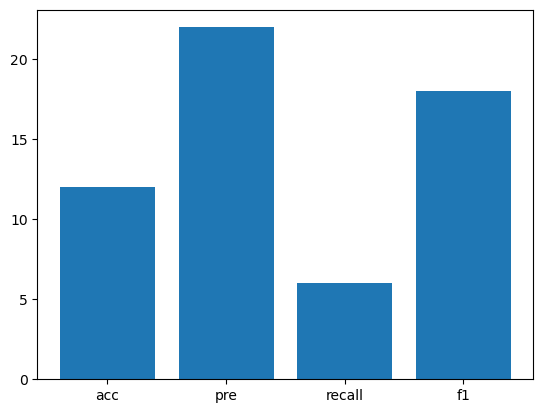

draw...


In [3]:
import matplotlib.pyplot as plt
import numpy as np
import os


def draw():
    print("draw...")


    x = np.array(["acc", "pre", "recall", "f1"])
    y = np.array([12, 22, 6, 18])

    plt.bar(x,y)
    plt.show()
    print("draw...")
# draw()

if __name__ == '__main__':
    draw()